<a href="https://colab.research.google.com/github/youcef-benmohammed/blood.group.detection/blob/main/Blood_Group_Detection_Using_Image_Processing_and_Deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Group Detection Using Image Processing and Deep learning

## Introduction



Paper :
[A Novel Approach to Predict Blood Group using Fingerprint Map Reading](https://www.researchgate.net/publication/351487579_A_Novel_Approach_to_Predict_Blood_Group_using_Fingerprint_Map_Reading)

## Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### Parmeters

## Load the read

There are 8 diffrent blood groups (clasees), as following:



*   **0: A+;**
*   **1: A-;**
*   **2: AB+;**
*   **3: AB-;**
*   **4: B+;**
*   **5: B-;**
*   **6: O+;**
*   **7: O-**.



In [3]:
# Import the dataset from kaggle
# install Kaggle library
!pip install -q kaggle


In [5]:
# Upload Kaggle json file!
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset > /dev/null 2>&1

In [8]:
!unzip -q finger-print-based-blood-group-dataset.zip -d /content/dataset

In [9]:
import os
import glob
file_path = '/content/dataset/dataset_blood_group/'
labels = os.listdir(file_path)
print(labels)

['B+', 'AB-', 'A-', 'A+', 'O+', 'AB+', 'O-', 'B-']


In [10]:
filepaths = list(glob.glob(file_path + '**/*.BMP'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [12]:
filepth = pd.Series(filepaths, name='filePath').astype(str)
labels = pd.Series(labels, name='label')
df = pd.concat([filepth, labels], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filePath,label
0,/content/dataset/dataset_blood_group/A+/cluste...,A+
1,/content/dataset/dataset_blood_group/A+/cluste...,A+
2,/content/dataset/dataset_blood_group/B-/cluste...,B-
3,/content/dataset/dataset_blood_group/AB-/clust...,AB-
4,/content/dataset/dataset_blood_group/AB+/clust...,AB+


In [13]:

labels = {'A+': 0, 'A-': 1,'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7 }

# function to get class distribution
def get_class_distribution(df, verbose=True):
    labels_count = df['label'].value_counts()
    total_sample = len(df)

    for label, count in labels_count.items():
        percentage = round(count / total_sample * 100, 2)
        print("{:<20s}:   {} or {}%".format(label, count, percentage))

get_class_distribution(df)


A-                  :   1009 or 16.82%
O+                  :   852 or 14.2%
AB-                 :   761 or 12.68%
B-                  :   741 or 12.35%
O-                  :   712 or 11.87%
AB+                 :   708 or 11.8%
B+                  :   652 or 10.87%
A+                  :   565 or 9.42%


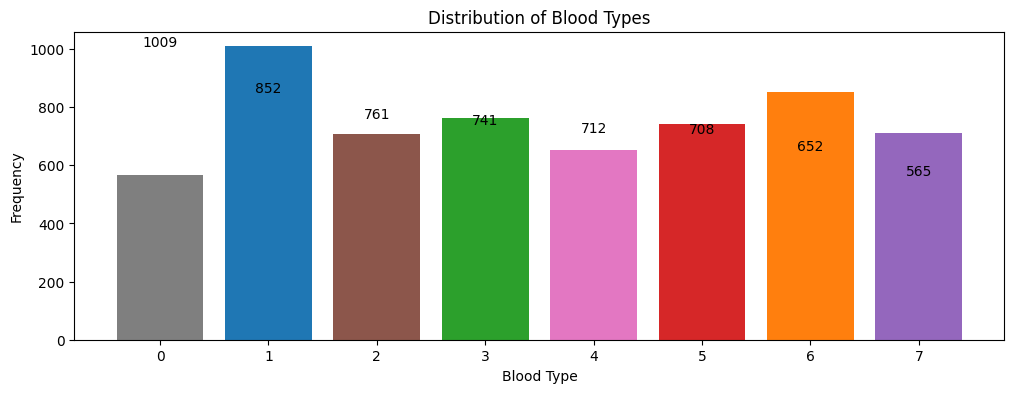

In [36]:
def plot_label_per_class(data, label='label'):
    blood_type_counts = data[label].value_counts()
    plt.figure(figsize=(12, 4))
    colors = plt.cm.tab10(range(len(blood_type_counts)))
    plt.bar(blood_type_counts.index, blood_type_counts.values, color=colors)
    plt.xlabel('Blood Type')
    plt.ylabel('Frequency')
    plt.title('Distribution of Blood Types')
    for i, count in enumerate(blood_type_counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.show()

plot_label_per_class(df, label='category_encoded')

In [35]:
df.head()

,filePath,category_encoded
0,/content/dataset/dataset_blood_group/A+/cluste...,0
1,/content/dataset/dataset_blood_group/A+/cluste...,0
2,/content/dataset/dataset_blood_group/B-/cluste...,5
3,/content/dataset/dataset_blood_group/AB-/clust...,3
4,/content/dataset/dataset_blood_group/AB+/clust...,2


In [16]:
import numpy as np
import pandas as pd
from PIL import Image  # Import PIL for image processing
# Image dimensions
IMG_ROWS = 128
IMG_COLS = 128
BATCH_SIZE = 32

def sample_images_data(data, labels):
    sample_images = []
    sample_labels = []

    # Itérer sur chaque label dans le dictionnaire
    for label in labels.keys():
        # Obtenir jusqu'à 4 échantillons correspondant à chaque label
        samples = data[data['label'] == label].head(4)

        for j in range(len(samples)):
            # Charger l'image à partir du chemin de fichier
            img_path = samples.iloc[j]['filePath']
            img = Image.open(img_path).convert("L") # Ouvrir l'image et la convertir en RGB

            # Redimensionner l'image aux dimensions souhaitées
            img = img.resize((IMG_COLS, IMG_ROWS))
            img_array = np.array(img)  # Convertir l'image en tableau numpy

            sample_images.append(img_array)
            sample_labels.append(samples.iloc[j]['label'])  # Utiliser la colonne label

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

sample_images, sample_labels = sample_images_data(df, labels)


Total number of sample images to plot:  32


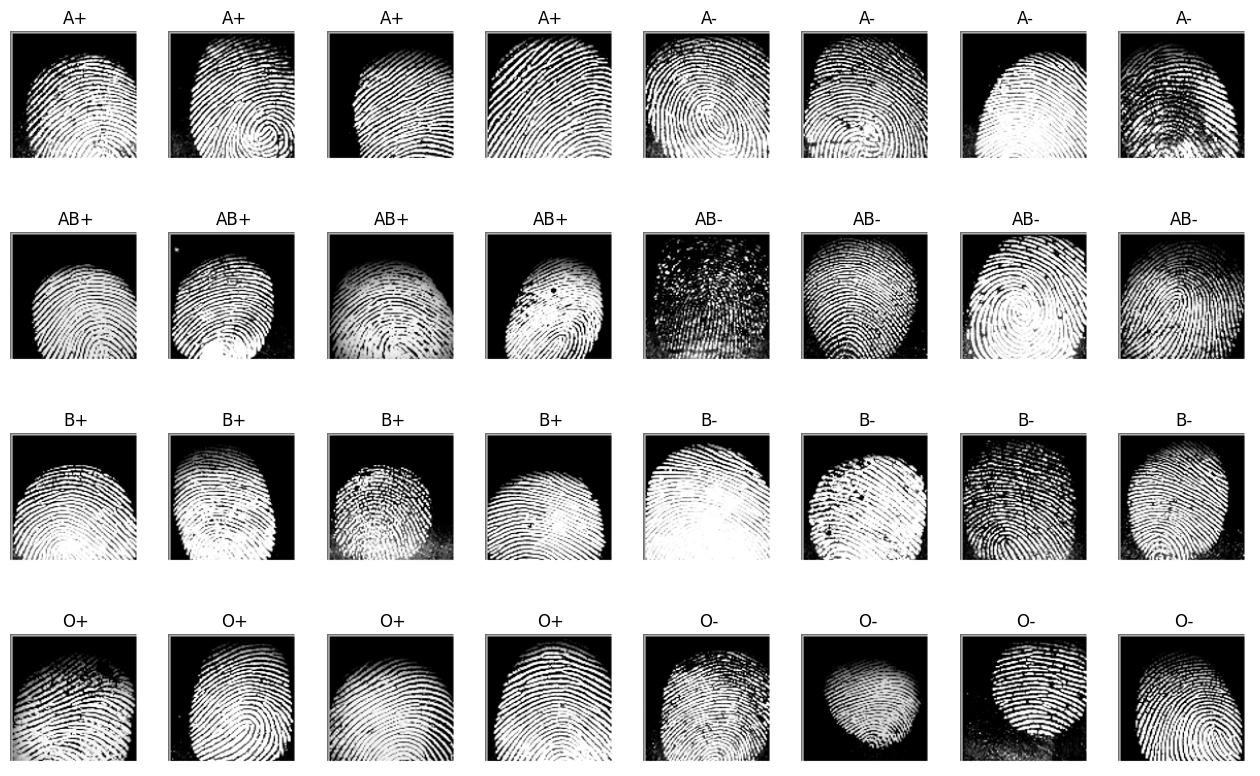

In [17]:
def plot_images(images, labels, cmap="Blues"):
    f, ax = plt.subplots(4,8, figsize=(16,10))

    for i, img in enumerate(images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[i])
    plt.show()
plot_images(sample_images, sample_labels, cmap='Greys')


## Split data

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [24]:
df.head(10)

,filePath,label,category_encoded
0,/content/dataset/dataset_blood_group/A+/cluste...,A+,0
1,/content/dataset/dataset_blood_group/A+/cluste...,A+,0
2,/content/dataset/dataset_blood_group/B-/cluste...,B-,5
3,/content/dataset/dataset_blood_group/AB-/clust...,AB-,3
4,/content/dataset/dataset_blood_group/AB+/clust...,AB+,2
5,/content/dataset/dataset_blood_group/AB-/clust...,AB-,3
6,/content/dataset/dataset_blood_group/AB+/clust...,AB+,2
7,/content/dataset/dataset_blood_group/AB-/clust...,AB-,3
8,/content/dataset/dataset_blood_group/O-/cluste...,O-,7
9,/content/dataset/dataset_blood_group/O+/cluste...,O+,6


In [25]:
df = df[['filePath', 'category_encoded']]

In [27]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['filePath']], df['category_encoded'])

In [28]:
df_resampled = pd.DataFrame(X_resampled, columns=['filePath'])
df_resampled['category_encoded'] = y_resampled

In [30]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    1009
5    1009
3    1009
2    1009
7    1009
6    1009
4    1009
1    1009
Name: count, dtype: int64


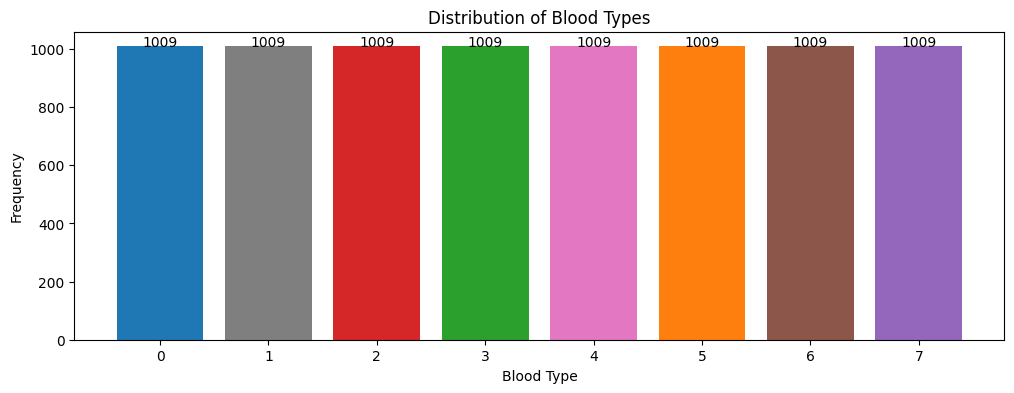

In [37]:
plot_label_per_class(df_resampled, label='category_encoded')

In [38]:
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [39]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [40]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded']
)

In [47]:
df_resampled.shape

(8072, 2)

In [48]:
train_df_new.shape

(6457, 2)

In [46]:
test_df_new.shape

(808, 2)

In [45]:
valid_df_new.shape

(807, 2)

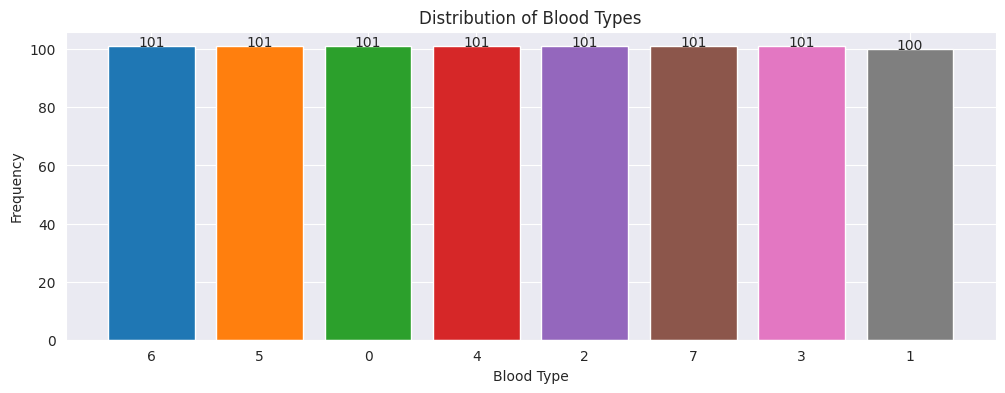

In [49]:
plot_label_per_class(valid_df_new, label='category_encoded')

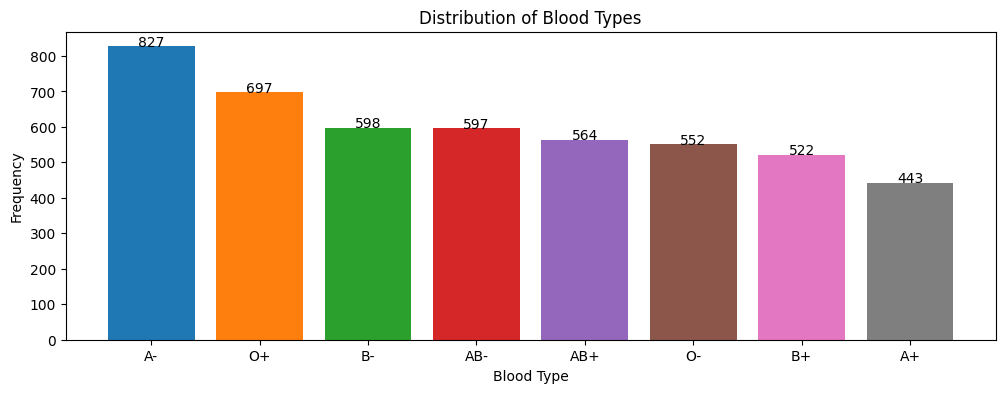

In [ ]:
plot_label_per_class(train_data)

In [50]:
#plot_label_per_class(test_data)

In [51]:
#sample_images, sample_labels = sample_images_data(train_data, labels)
#plot_images(sample_images, sample_labels, cmap='magma')

In [52]:
#sample_images, sample_labels = sample_images_data(test_data, labels)
#plot_images(sample_images, sample_labels, cmap='cividis')

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 6457 validated image filenames belonging to 8 classes.
Found 807 validated image filenames belonging to 8 classes.
Found 808 validated image filenames belonging to 8 classes.


In [ ]:
pretrained_model = ResNet50(
      include_top=False,
      input_shape=(IMG_ROWS, IMG_COLS, 3),
      weights='imagenet',
      pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks = [EarlyStopping(monitor="val_accuracy", patience=2,
                              min_delta=0, mode="auto")]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

# TODO LISt

- **Ajustements de l’architecture :** Tester d’autres architectures de modèles CNN, ou à fine-tuner ResNet50 si les ressources le permettent.
    -  Augmenter le Drop-out pour éviter le sur-apprentissage 🔑

- **Evaulation des performances :** Ajout d'un métrique de la fonction loss, F1-score, matrice de confusion  


- **Interprétation des résultats :** Un aspect intéressant serait d'étudier les zones des empreintes digitales qui influencent le plus le modèle en utilisant des méthodes d'interprétabilité comme Grad-CAM.

- **Bilan des performances :** Documenter les performances de chaque groupe sanguin pour identifier les potentiels biais ou classes mal prédictibles. Matrice de confusion pour chaque classe par exemple.
